# F583-4 (FDMc)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import warnings
import corner
import math
from IPython.display import display, Math
from scipy.stats import norm
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#Membaca data kecepatan rotasi
gal = pd.read_excel('SPARC_RotCur.xlsx', sheet_name='Fisis')
d = pd.read_excel('SPARC_RotCur.xlsx', sheet_name='RotCur')
df = d.loc[d['ID'] == 'F583-4'].reset_index(drop=True)
df

,ID,D,R,Vobs,e_Vobs,Vgas,Vdisk,Vbul,Sbdisk,Sbbul
0,F583-4,53.3,0.22,10.7,4.90,0.47,5.59,0.0,69.18,0.0
1,F583-4,53.3,0.76,24.7,4.90,1.87,17.63,0.0,60.07,0.0
2,F583-4,53.3,1.31,38.9,4.90,3.27,26.64,0.0,42.04,0.0
3,F583-4,53.3,1.94,42.7,7.89,4.87,32.27,0.0,31.07,0.0
4,F583-4,53.3,3.92,55.0,4.90,8.50,38.26,0.0,9.64,0.0
5,F583-4,53.3,4.35,57.2,4.90,9.17,38.43,0.0,8.68,0.0
6,F583-4,53.3,5.00,59.8,4.90,10.30,39.09,0.0,6.38,0.0
7,F583-4,53.3,5.05,62.5,3.43,10.40,39.06,0.0,6.20,0.0
8,F583-4,53.3,5.83,61.8,3.98,12.10,38.38,0.0,3.70,0.0
9,F583-4,53.3,6.09,64.4,4.90,12.72,38.13,0.0,3.52,0.0


In [4]:
rad = df['R'] #kpc
Vobs = df['Vobs'] #km/s
Vobs_err = df['e_Vobs'] #km/s
Vgas = df['Vgas'] #km/s
Vdisk = df['Vdisk'] #km/s

item_index = gal[gal['ID'] == 'F583-4'].index[0]
r_star = gal.loc[item_index, 'Rdisk']
r_gas = 3*r_star
r_eff = gal.loc[item_index, 'Reff']
gal['Mstar'] = gal.L*10**9
gal['Mgas'] = 1.33*gal.MHI*10**9
M_star_a = gal.loc[item_index, 'Mstar']
M_gas_a = gal.loc[item_index, 'Mgas']

In [5]:
#MCMC
def main(p0, nwalkers, niter, ndim, ln_posterior, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=data)

    print("Running burn-in...")
    p0 = sampler.run_mcmc(p0, 500, progress=True) #500 iterasi pertama ditetapkan sebagai burn-in
    sampler.reset() #reset sampler sebelum melakukan iterasi utama

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

## Model Halo FDMc

In [6]:
H0 = 0.0678 #km/s/kpc
rho_c0 = 1.2744e-7 # Msun pc^-3

def fsol(x):
    fs = 1/((1+0.091*(x**2))**8)
    return fs

def Isol(alpha, x):
    if isinstance(x, float):
        if x < alpha:
            u = np.sqrt(0.091)*x
            isol = (3465*(u**13 - u + ((u**2+1)**7)*np.arctan(u)) + 23100*(u**11) + 65373*(u**9) + 101376*(u**7) + 92323*(u**5) + 48580*(u**3))/(5903.116304*((u**2 + 1)**7))
            return isol
        else: # alpha < x
            ua = np.sqrt(0.091)*alpha
            isol = (3465*(ua**13 - ua + ((ua**2+1)**7)*np.arctan(ua)) + 23100*(ua**11) + 65373*(ua**9) + 101376*(ua**7) + 92323*(ua**5) + 48580*(ua**3))/(5903.116304*((ua**2 + 1)**7))
            return isol
    else:
        isola = []
        for i in range(len(x)):
            if x[i] < alpha:
                u = np.sqrt(0.091)*x[i]
                isol = (3465*(u**13 - u + ((u**2+1)**7)*np.arctan(u)) + 23100*(u**11) + 65373*(u**9) + 101376*(u**7) + 92323*(u**5) + 48580*(u**3))/(5903.116304*((u**2 + 1)**7))
                isola.append(isol)
            else: # alpha < x[i]
                ua = np.sqrt(0.091)*alpha
                isol = (3465*(ua**13 - ua + ((ua**2+1)**7)*np.arctan(ua)) + 23100*(ua**11) + 65373*(ua**9) + 101376*(ua**7) + 92323*(ua**5) + 48580*(ua**3))/(5903.116304*((ua**2 + 1)**7))
                isola.append(isol)
        return isola

def INFW(x1, x2):
    if isinstance(x2, float):
        infw = np.log(np.abs((x2+1)/(x1+1))) + 1/(x2+1) - 1/(x1+1)
        if infw >= 0.0:
            return infw
        else: # infw < 0.0
            return 0.0
    else:
        infwa = []
        for i in range(len(x2)):
            infw = np.log(np.abs((x2[i]+1)/(x1+1))) + 1/(x2[i]+1) - 1/(x1+1)
            if infw >= 0.0:
                infwa.append(infw)
            else: # infw < 0.0
                infwa.append(0.0)
        return infwa
    
def mu(x, alpha, beta):
    K = (beta**6)*((fsol(alpha))**2)
    mu_x = []
    Is = Isol(alpha, x)
    IN = INFW(alpha/beta, x/beta)
    for i in range(len(x)):
        mux = Is[i] + K*IN[i]
        mu_x.append(mux)
    return mu_x

# Halo FDMc, parameter bebas V200, m22, alpha, delta, M/l
def VFDMc(V200, logm22, alpha, delta, C200n, r):
    C200 = (0.0537*(10**logm22)*delta*(V200**2)*(rho_c0**(1/3)))/(H0**2)
    mu_C200 = (0.350877*((10**logm22)**2)*rho_c0*(V200**4))/(C200*(H0**4))
    rs = V200 / (0.678 * C200) # kpc
    x = r/rs
    beta0 = 1.0 # initial
    dbeta = 1.0 # initial
    beta = 1.0 # initial
    rep = 0 # initial
    while dbeta > 0.0001:
        rep += 1
        beta = ((mu_C200 - Isol(alpha, C200))/(((fsol(alpha))**2)*INFW(alpha/beta0, C200/beta0)))**(1/6)
        if not np.isfinite(beta):
            break
        dbeta = np.abs(beta - beta0)
        beta0 = beta
        if rep == 50: # batas iterasi maksimum
            beta = np.inf
            break
    if not np.isfinite(beta):
        vf = np.asarray([0.0 for i in range(len(x))])
        C200n = C200/beta
        return vf, beta, C200n
    else:
        vf = V200 * np.sqrt((C200/x)*(mu(x, alpha, beta)/mu_C200))
        C200n = C200/beta
        return vf, beta, C200n

#Fungsi model kecepatan rotasi total
def Vtot(ML_d, vDM, Vdisk, Vgas):
    return np.sqrt(vDM**2 + ML_d*(Vdisk**2) + Vgas*np.abs(Vgas))

In [7]:
#Likelihood
def ln_likelihood(theta, r, Vobs, Vdisk, Vgas, Vobs_err):
    V200, logm22, alpha, delta, C200n, ML_d = theta
    vDM, beta, C200n = VFDMc(V200, logm22, alpha, delta, C200n, r)
    if np.sum(vDM) == 0.0:
        lik = -np.inf
        return lik
    else:
        vtot = Vtot(ML_d, vDM, Vdisk, Vgas)
        lik = np.sum(-np.log(np.sqrt(2*math.pi)*Vobs_err) - ((Vobs - vtot)**2)/(2*(Vobs_err**2)))
        return lik

#Prior
def ln_prior(theta):
    V200, logm22, alpha, delta, C200n, ML_d = theta
    if 10.0 < V200 < 100.0: # km/s
        p1 = 1/90
    else:
        p1 = 0.0
    if -3.0 < logm22 < 3.0:
        p2 = 1/6
    else:
        p2 = 0.0
    if 1.0 < alpha < 4.5:
        p3 = 1/3.5
    else:
        p3 = 0.0
    if 0.5 < delta < 1.5:
        p4 = 1
    else:
        p4 = 0.0
    if C200n > 0.0:
        H0 = 67.8
        G = 4.3e-6
        r200_pred = 1000 * V200 / (10*H0)
        M200_pred = V200 ** 2 * r200_pred / G
        C200_pred = 10**(0.905 - (0.101 * np.log10(M200_pred / (10 ** 12 * ((H0/100) ** -1)))))
        C200_FDM = ((1+(15*((1.6*10**10*(10**logm22)**(-4/3))/M200_pred)))**(-0.3))*C200_pred
        p5 = norm.pdf(x=C200n, loc=C200_FDM, scale= (10 ** 0.16 - 1) * 0.5)
    else:
        p5 = 0
    if ML_d > 0.0:
        p6 = norm.pdf(x=ML_d, loc=0.5, scale=(10**0.1 - 1)*0.5)
    else:
        p6 = 0
    return np.log(p1*p2*p3*p4*p5*p6)

#Posterior = (Likelihood * Prior)/Evidence
def ln_posterior(theta, r, Vobs, Vdisk, Vgas, Vobs_err):
    lp = ln_prior(theta)
    ll = ln_likelihood(theta, r, Vobs, Vdisk, Vgas, Vobs_err)
    if (not np.isfinite(lp)) or (not np.isfinite(ll)):
        return -np.inf
    else:
        return lp + ll

## MCMC FDMc

In [8]:
#Menjalankan MCMC
nwalkers = 50 #number of walkers
niter = 50000 #number of iterations
init_param = np.array([53.0, 0.5, 1.6, 0.53, 4, 0.52]) #V200, logm22, alpha, delta, M/L ambil semuanya secara sembarang dalam rentang prior
ndim = len(init_param) #number of dimension
p0 = [np.array(init_param) + np.array(init_param)*1e-7*np.random.normal(size=np.array(init_param).size) for i in range(nwalkers)] #methodology of stepping from one place to a grid to the next

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,ln_posterior,(rad, Vobs, Vdisk, Vgas, Vobs_err)) #run MCMC

Running burn-in...


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:46<00:00, 10.71it/s]


Running production...


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [1:24:57<00:00,  9.81it/s]


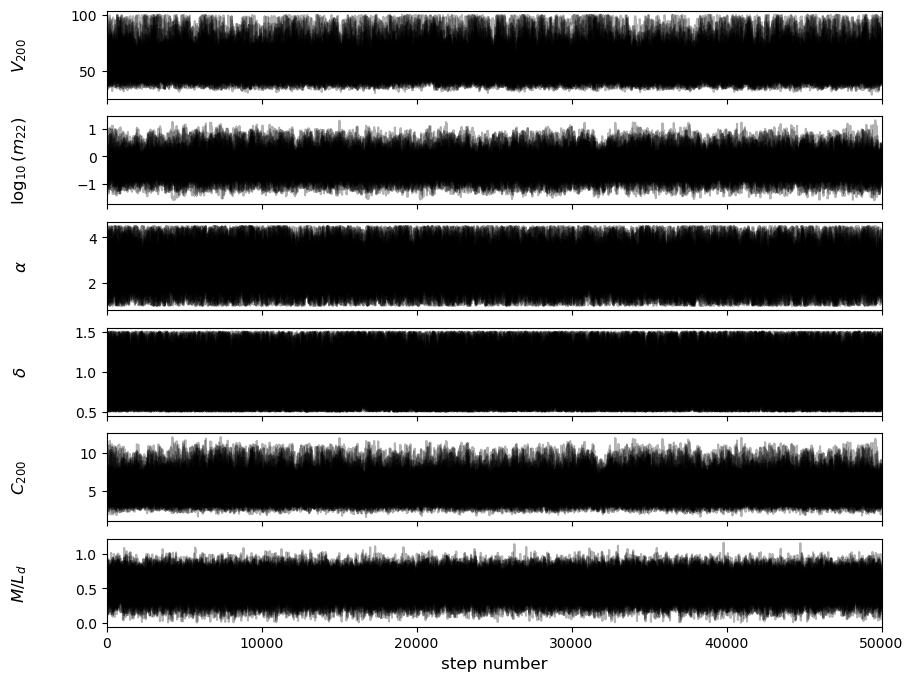

In [9]:
#Membuat plot masing-masing parameter (MCMC chains) untuk mengecek konvergensi
fig, axes = plt.subplots(ndim, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = [r"$V_{200}$", r"$\log_{10}(m_{22})$", r"$\alpha$", r"$\delta$", r"$C_{200}$", r"$M/L_d$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=12)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontsize=12);
plt.savefig('Trace plot {} (FDMc).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi=300)

In [10]:
# Flat: concatenating the samples from each walker in the chain
# Discard: menghapus X sampel (flattened) pertama
# Thin: mengambil sampel kelipatan ke-X saja (untuk merampingkan sampel dan menghemat ukuran sampel)
flat_samples = sampler.get_chain(discard=1500, thin=30, flat=True)
np.savetxt("Flat samples {} (FDMc).txt".format(df['ID'][0]), np.c_[flat_samples[:, 0],flat_samples[:, 1],flat_samples[:, 2],flat_samples[:, 3],flat_samples[:, 4],flat_samples[:, 5]])

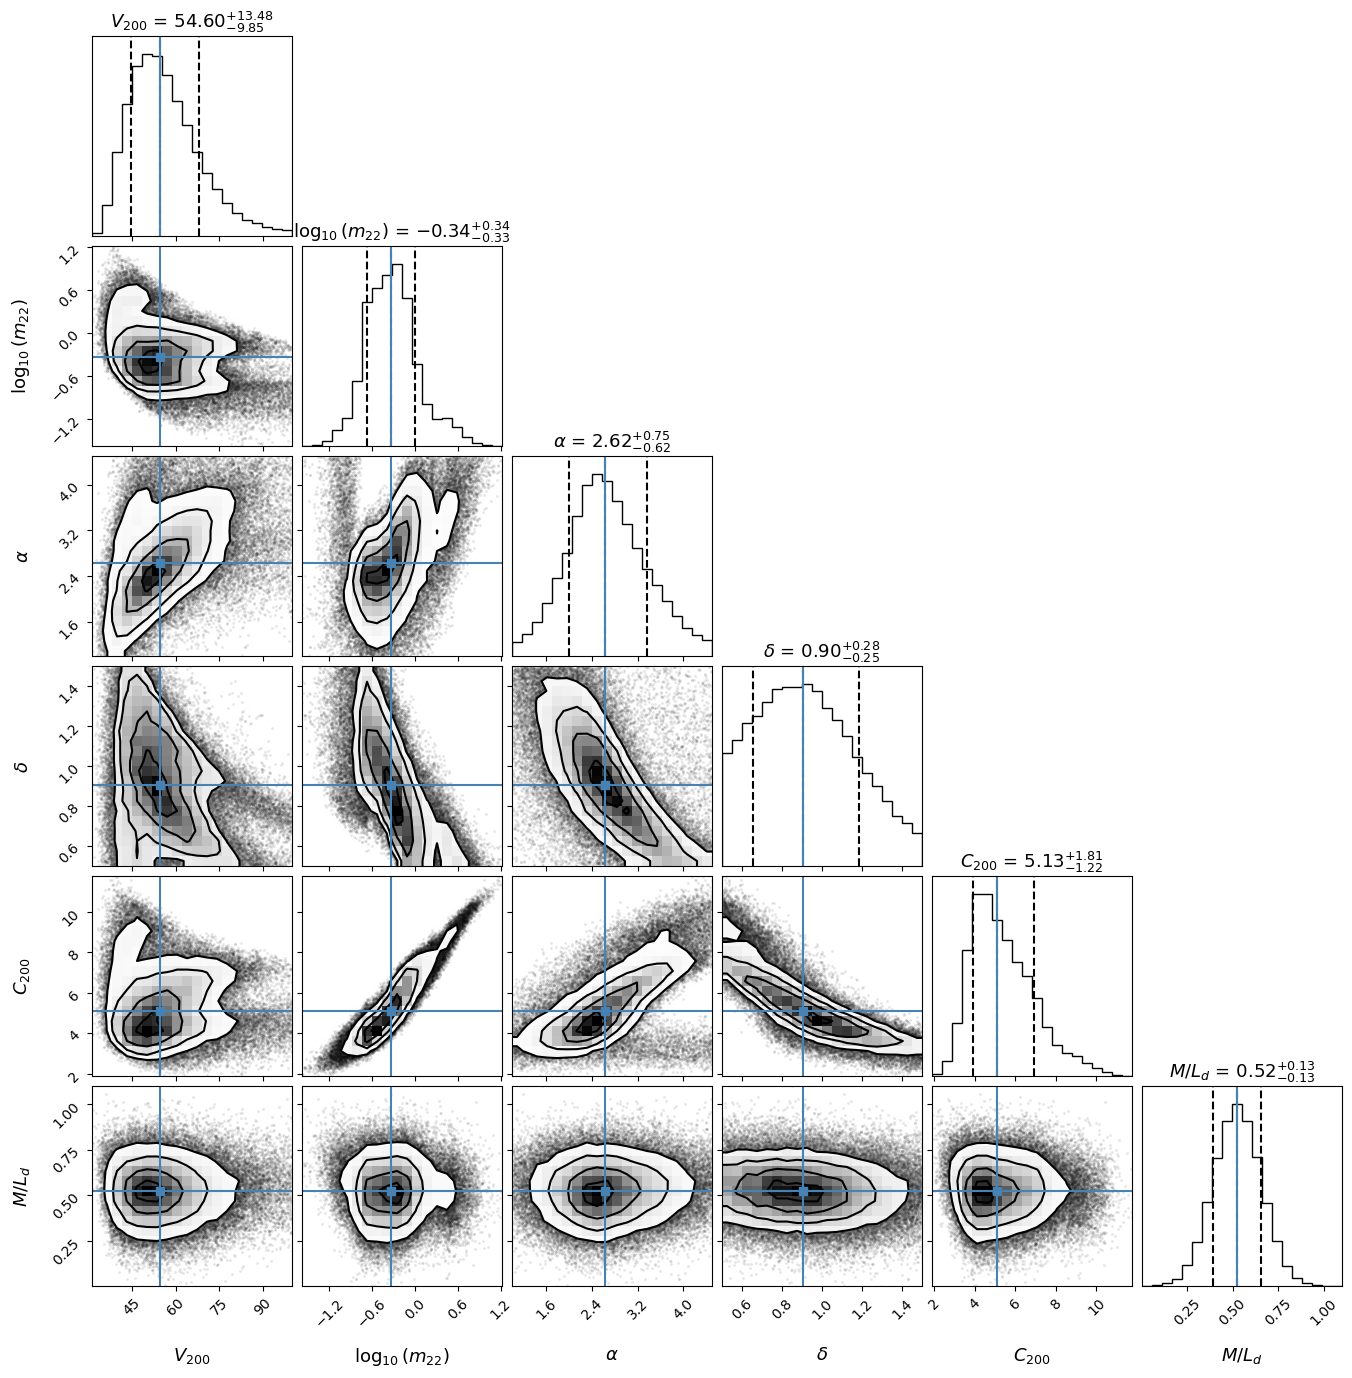

In [8]:
#Membuat corner plot
#Menyimpan nilai best-fit parameter hasil MCMC
flat_samples = np.loadtxt("Flat samples {} (FDMc).txt".format(df['ID'][0]))
labels = [r"$V_{200}$", r"$\log_{10}(m_{22})$", r"$\alpha$", r"$\delta$", r"$C_{200}$", r"$M/L_d$"]
V200 = np.median(flat_samples[:, 0])
logm22 = np.median(flat_samples[:, 1])
alpha = np.median(flat_samples[:, 2])
delta = np.median(flat_samples[:, 3])
C200n = np.median(flat_samples[:, 4])
ML_d = np.median(flat_samples[:, 5])

fig = corner.corner(flat_samples,show_titles=True,title_kwargs={"fontsize":13},labels=labels,label_kwargs={"fontsize":13},plot_datapoints=True,truths=[V200,logm22,alpha,delta,C200n,ML_d],quantiles=[0.16, 0.5, 0.84],dpi=200)
plt.savefig('Corner plot {} (FDMc).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi=300)

In [9]:
#Menghitung kecepatan komponen halo DM dan kecepatan total menggunakan nilai best-fit
vDM, beta, C200n = VFDMc(V200, logm22, alpha, delta, C200n, rad)
vtot = Vtot(ML_d, vDM, Vdisk, Vgas)

In [10]:
#Menuliskan nilai best-fit parameter hasil MCMC dan reduced chi squared
labels2 = [r'V_{200}', r'log_{10}(m_{22})', r'\alpha', r'\delta', r'C_{200}', r'M/L_d']
ndim = 6
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels2[i])
    display(Math(txt))

C200 = (0.0537*(10**logm22)*delta*(V200**2)*(rho_c0**(1/3)))/(H0**2)
tC200 = "\mathrm C_{{200}} = {0:.3f}".format(C200)
rs = V200 / (0.678 * C200)
trs = "\mathrm r_{{s}} = {0:.3f} \, \\textrm{{kpc}}".format(rs)
ra = alpha*rs
tra = "\mathrm r_{{a}} = {0:.3f} \, \\textrm{{kpc}}".format(ra)
r200 = C200*rs
tr200 = "\mathrm r_{{200}} = {0:.3f} \, \\textrm{{kpc}}".format(r200)
G = 4.3e-6
m200 = np.log10(V200 ** 2 * r200 / G)
tm200 = "$\log M_{{200,\mathrm{{FDMc}}}} (\mathrm{{M_{{\odot}}}}) = {0:.3f}$".format(m200)
display(Math(tC200))
display(Math(trs))
display(Math(tra))
display(Math(tr200))
display(Math(tm200))

chisq = 0.
for i in range(len(rad)):
    chisq = chisq + (((Vobs[i] - vtot[i])**2)/(Vobs_err[i])**2)

red_chisq = chisq/(len(rad) - ndim) #reduced chi squared
txt2 = "\mathrm\chi_{{\\nu}}^2 = {0:.3f}".format(red_chisq)
display(Math(txt2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
print("Mean autocorrelation time (FDMc): {0:.4f}".format(np.mean(sampler.get_autocorr_time())))

Mean autocorrelation time (FDMc): 252.4977


In [15]:
print("Mean acceptance fraction (FDMc): {0:.4f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction (FDMc): 0.3716


In [11]:
#Komponen kecepatan disk adalah akar dari (ML_d * (Vdisk**2)), dari Li et al. 2020
Vdisk_f = []
for i in range(len(rad)):
    vdisk_f = np.sqrt(ML_d) * (Vdisk[i])
    Vdisk_f.append(vdisk_f)
np.savetxt('Mass model {} (FDMc).txt'.format(df['ID'][0]), np.c_[rad,Vobs,Vobs_err,Vgas,Vdisk_f,vDM,vtot], fmt='% 1.3f', header='R     Vobs    eVobs  Vgas    Vdisk   VDM     Vtot')

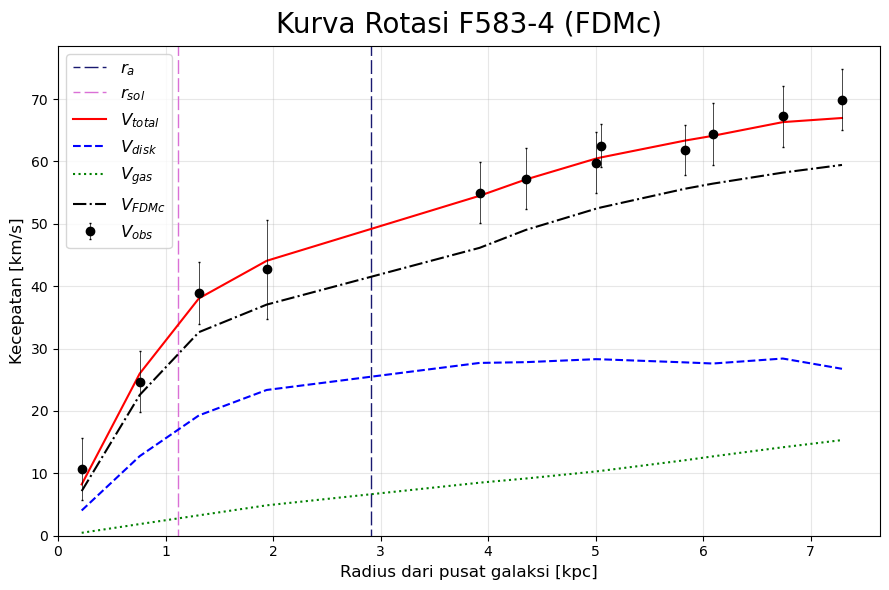

In [12]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
plt.axvline(x = ra, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_a$')
plt.axvline(x = rs, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_{sol}$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{FDMc}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (FDMc)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} (FDMc).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 300)
plt.show()

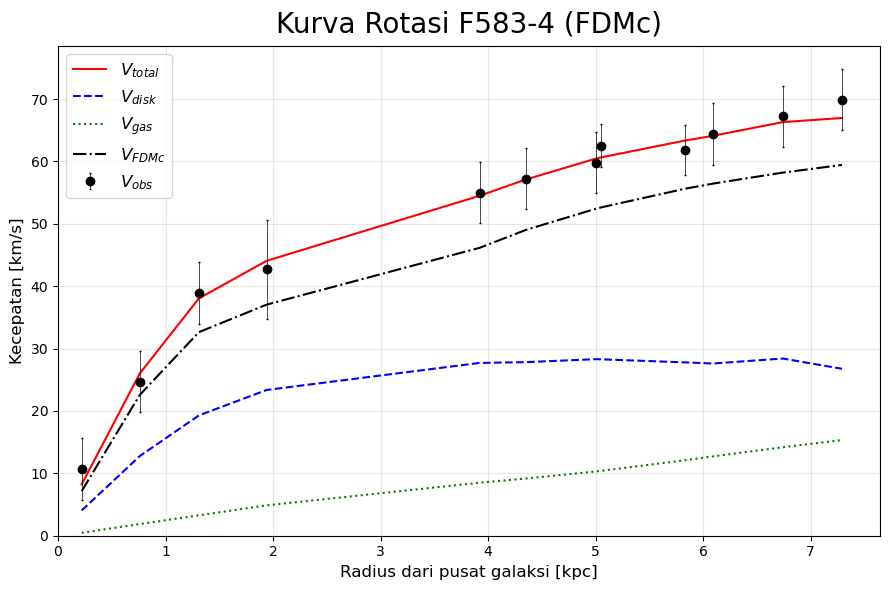

In [13]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
#plt.axvline(x = ra, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_a$')
#plt.axvline(x = rs, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_{sol}$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{FDMc}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (FDMc)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} (FDMc) 2.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 300)
plt.show()

In [14]:
rsmooth = np.linspace(df['R'][0], df['R'][df['R'].argmax()], 1000)
vDM, beta, C200n = VFDMc(V200, logm22, alpha, delta, C200n, rsmooth)

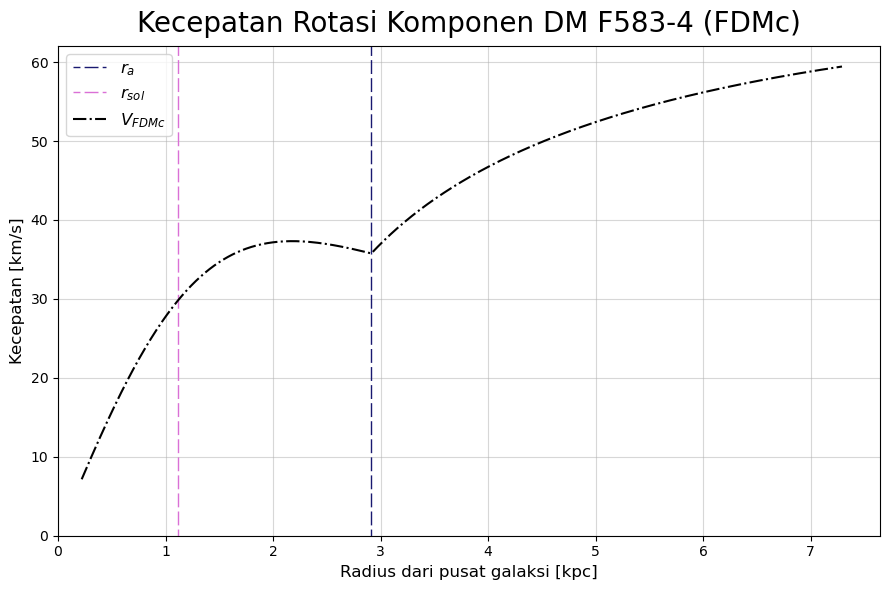

In [15]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
#plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
#plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
#plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
#plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.axvline(x = ra, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_a$')
plt.axvline(x = rs, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_{sol}$')
plt.plot(rsmooth, vDM, label = '$V_{FDMc}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kecepatan Rotasi Komponen DM {} (FDMc)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.5)
plt.savefig('Kecepatan Rotasi Komponen DM {} (FDMc).jpg'.format(df['ID'][0]), format = 'jpg', dpi = 150)
plt.show()

# 1sigma posterior spread

In [16]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        vDM, beta, C200n = VFDMc(i[0], i[1], i[2], i[3], i[4], rad)
        vtot = Vtot(i[5], vDM, Vdisk, Vgas)
        models.append(vtot)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(10000,flat_samples)

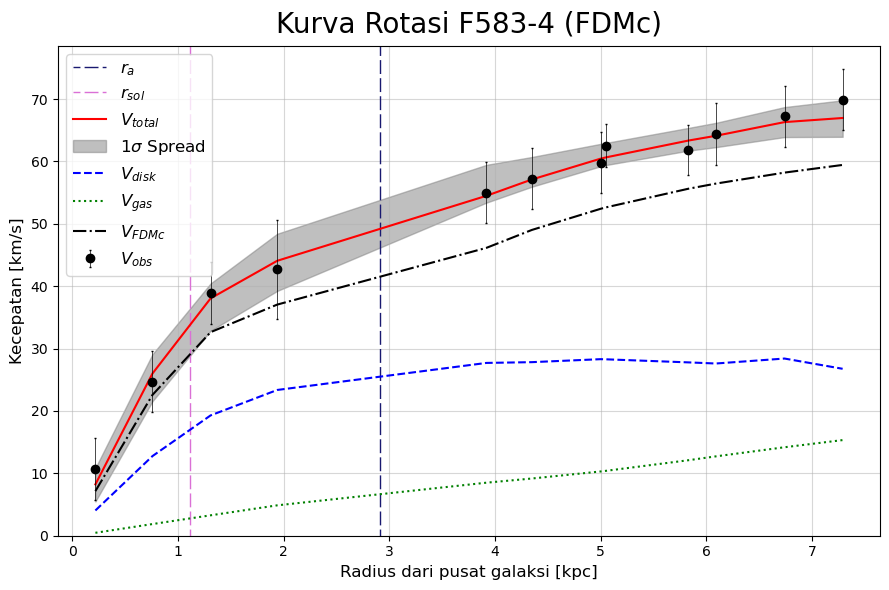

In [17]:
#Membuat plot kurva rotasi dengan 1sigma posterior spread
vDM, beta, C200n = VFDMc(V200, logm22, alpha, delta, C200n, rad)
plt.figure(figsize=(9,6))
plt.axvline(x = ra, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_a$')
plt.axvline(x = rs, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_{sol}$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.fill_between(rad,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Spread')
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{FDMc}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title(r'Kurva Rotasi {} (FDMc)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.5)
plt.savefig('Kurva Rotasi {} 1sigma (FDMc).jpg'.format(df['ID'][0]), format = 'jpg', dpi = 150)
plt.show()

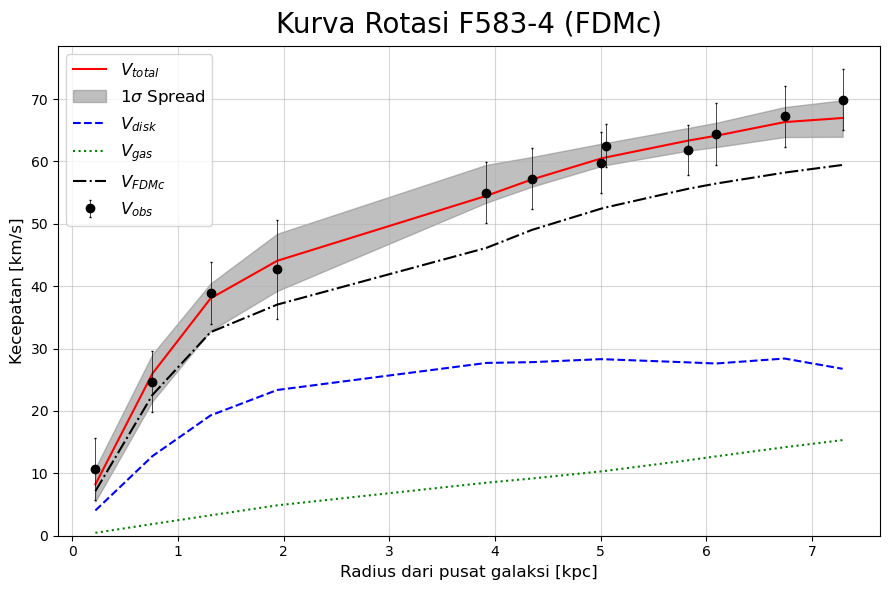

In [18]:
#Membuat plot kurva rotasi dengan 1sigma posterior spread
vDM, beta, C200n = VFDMc(V200, logm22, alpha, delta, C200n, rad)
plt.figure(figsize=(9,6))
#plt.axvline(x = ra, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_a$')
#plt.axvline(x = rs, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_{sol}$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.fill_between(rad,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Spread')
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{FDMc}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title(r'Kurva Rotasi {} (FDMc)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.5)
plt.savefig('Kurva Rotasi {} 1sigma (FDMc) 2.jpg'.format(df['ID'][0]), format = 'jpg', dpi = 150)
plt.show()

## Maximum A Posteriori

In [26]:
lnprob_samples = sampler.get_log_prob(discard=1500, thin=30, flat=True)
np.savetxt("Lnprob samples {} (FDMc).txt".format(df['ID'][0]), np.c_[lnprob_samples[:]])

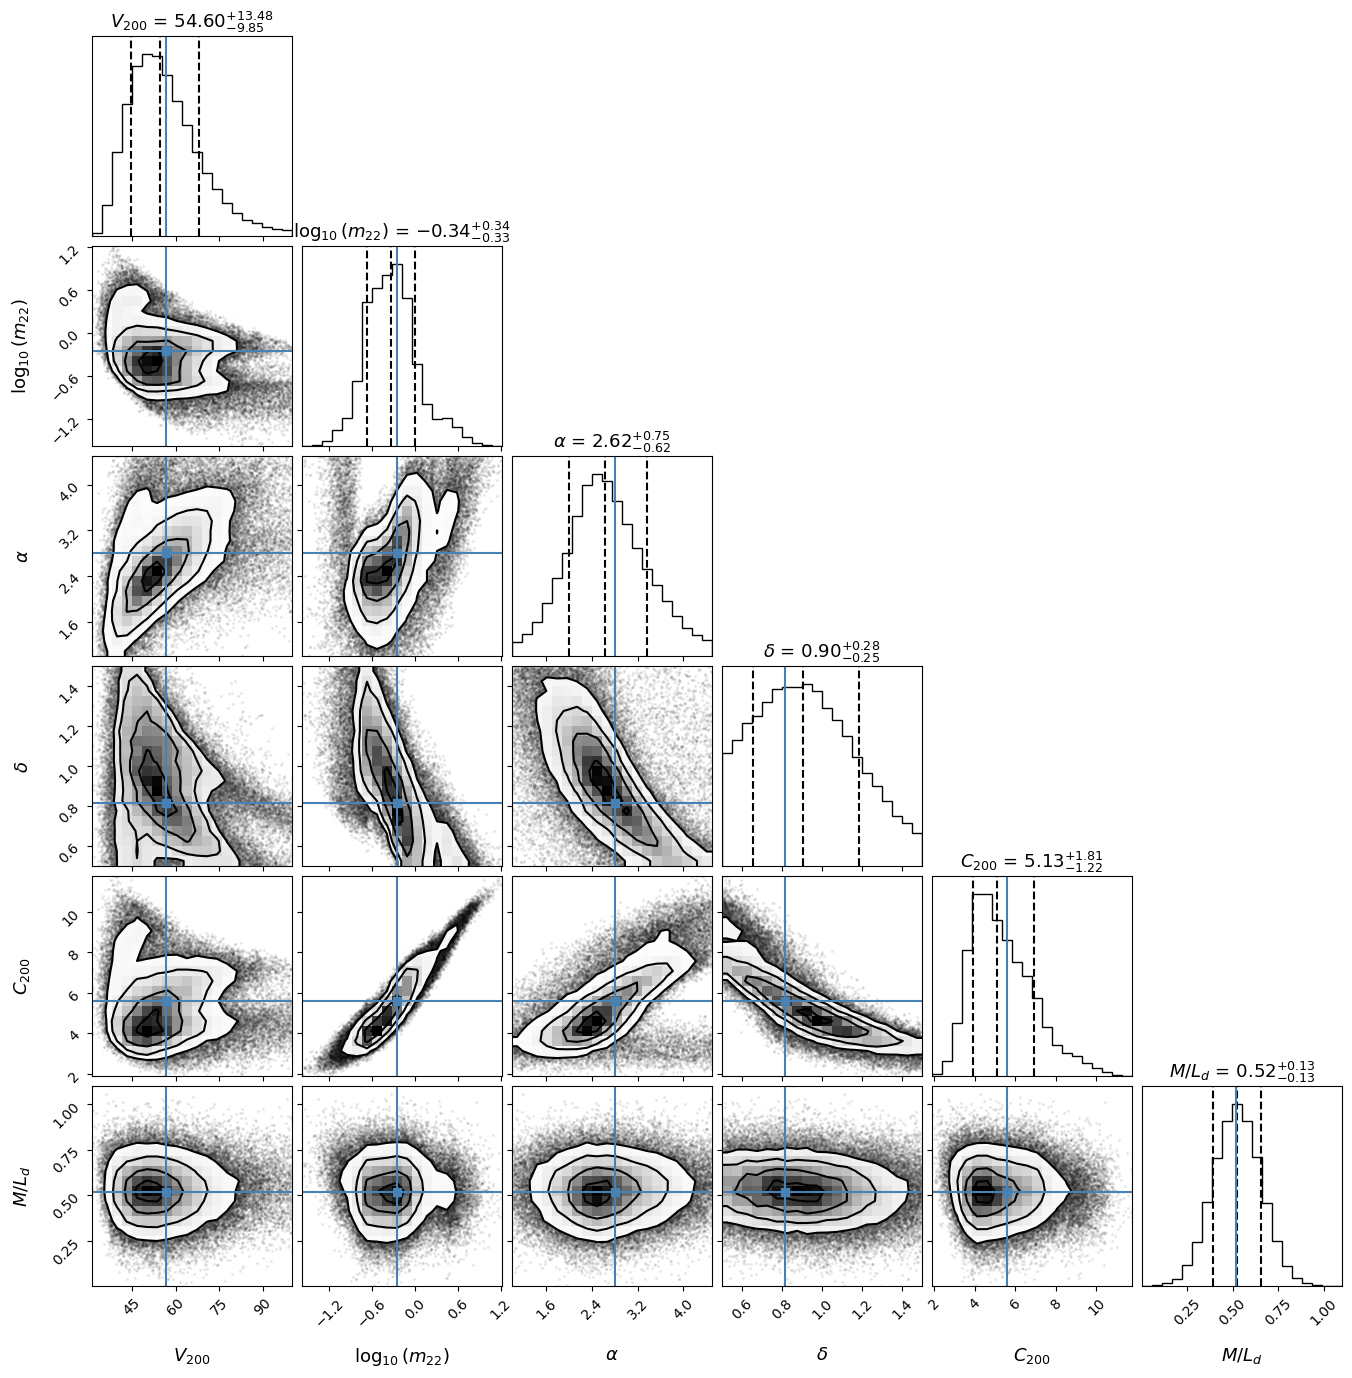

In [19]:
lnprob_samples = np.loadtxt("Lnprob samples {} (FDMc).txt".format(df['ID'][0]))
theta_max = flat_samples[np.argmax(lnprob_samples)]

#Menyimpan nilai best-fit parameter hasil MCMC
V200 = theta_max[0]
logm22 = theta_max[1]
alpha = theta_max[2]
delta = theta_max[3]
C200n = theta_max[4]
ML_d = theta_max[5]

fig = corner.corner(flat_samples,show_titles=True,title_kwargs={"fontsize":13},labels=labels,label_kwargs={"fontsize":13},plot_datapoints=True,truths=[V200,logm22,alpha,delta,C200n,ML_d],quantiles=[0.16, 0.5, 0.84],dpi=200)
plt.savefig('Corner plot MAP {} (FDMc).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi=300)

In [20]:
# Find the index of the maximum log-probability
max_lnprob_index = np.argmax(lnprob_samples)

# Calculate the maximum likelihood (exponent of the maximum log-probability)
max_likelihood = np.exp(lnprob_samples[max_lnprob_index])

# Number of parameters in the model
k = len(theta_max)

# Number of data points (assuming `n` is provided, e.g., `n` is the length of the data)
n = len(df)

# Calculate BIC
bic = k * np.log(n) - 2 * lnprob_samples[max_lnprob_index]

print("ml:", max_likelihood)
print("BIC:", bic)

np.savetxt('BIC {} (FDM).txt'.format(df['ID'][0]), np.c_[bic], fmt='% 1.3f', header='BIC')

ml: 1.533802558590987e-16
BIC: 87.7366629055658


In [36]:
#Menghitung kecepatan komponen halo DM dan kecepatan total menggunakan nilai best-fit
vDM, beta, C200n = VFDMc(V200, logm22, alpha, delta, C200n, rad)
vtot = Vtot(ML_d, vDM, Vdisk, Vgas)

In [37]:
#Menuliskan nilai best-fit parameter hasil MCMC dan reduced chi squared
for i in range(ndim):
    std = np.std(flat_samples[:, i])
    txt = "\mathrm{{{2}}} = {0:.6f} \pm {1:.6f}"
    txt = txt.format(theta_max[i], std, labels2[i])
    display(Math(txt))

C200 = (0.0537*(10**logm22)*delta*(V200**2)*(rho_c0**(1/3)))/(H0**2)
tC200 = "\mathrm C_{{200}} = {0:.3f}".format(C200)
rs = V200 / (0.678 * C200)
trs = "\mathrm r_{{s}} = {0:.3f} \, \\textrm{{kpc}}".format(rs)
ra = alpha*rs
tra = "\mathrm r_{{a}} = {0:.3f} \, \\textrm{{kpc}}".format(ra)
r200 = C200*rs
tr200 = "\mathrm r_{{200}} = {0:.3f} \, \\textrm{{kpc}}".format(r200)
G = 4.3e-6
m200 = np.log10(V200 ** 2 * r200 / G)
tm200 = "$\log M_{{200,\mathrm{{FDMc}}}} (\mathrm{{M_{{\odot}}}}) = {0:.3f}$".format(m200)
display(Math(tC200))
display(Math(trs))
display(Math(tra))
display(Math(tr200))
display(Math(tm200))
    
chisq = 0.
for i in range(len(rad)):
    chisq = chisq + ((Vobs[i] - vtot[i])**2) / (Vobs_err[i])**2

red_chisq = chisq/(len(rad) - ndim) #reduced chi squared
txt2 = "\mathrm\chi_{{\\nu}}^2 = {0:.3f}".format(red_chisq)
display(Math(txt2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [38]:
#Komponen kecepatan disk adalah akar dari (ML_d * (Vdisk**2)), dari Li et al. 2020
Vdisk_f = []
for i in range(len(rad)):
    vdisk_f = np.sqrt(ML_d) * (Vdisk[i])
    Vdisk_f.append(vdisk_f)
np.savetxt('Mass model MAP {} (FDMc).txt'.format(df['ID'][0]), np.c_[rad,Vobs,Vobs_err,Vgas,Vdisk_f,vDM,vtot], fmt='% 1.3f', header='R     Vobs    eVobs  Vgas    Vdisk   VDM     Vtot')

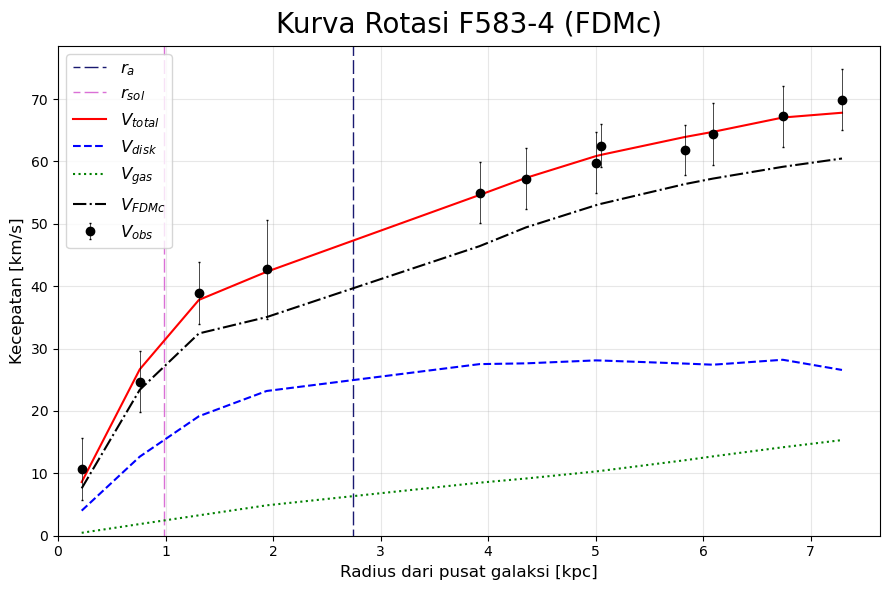

In [39]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
plt.axvline(x = ra, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_a$')
plt.axvline(x = rs, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_{sol}$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{FDMc}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (FDMc)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi MAP {} (FDMc).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 300)
plt.show()

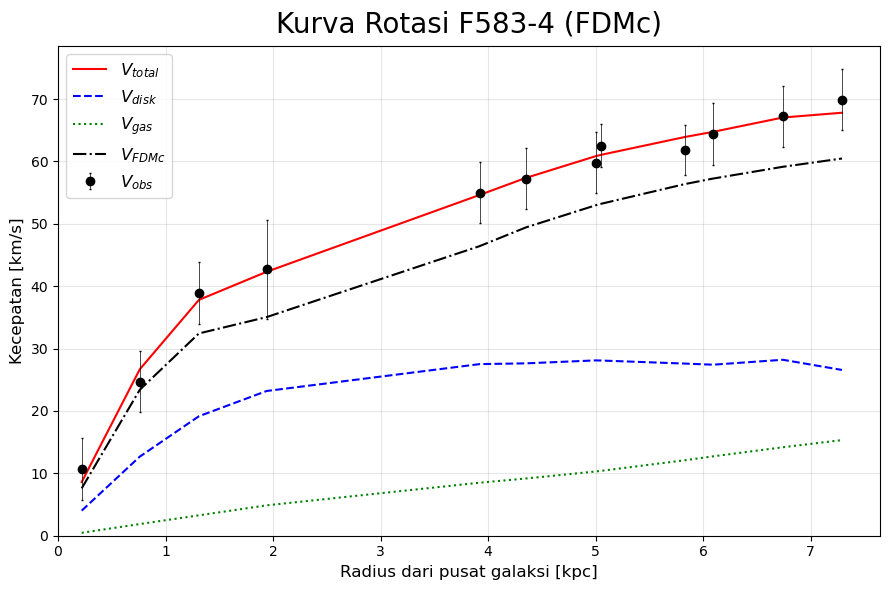

In [40]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
#plt.axvline(x = ra, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_a$')
#plt.axvline(x = rs, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_{sol}$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.plot(rad, vDM, label = '$V_{FDMc}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kurva Rotasi {} (FDMc)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi MAP {} (FDMc) 2.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 300)
plt.show()

In [41]:
vDM, beta, C200n = VFDMc(V200, logm22, alpha, delta, C200n, rsmooth)

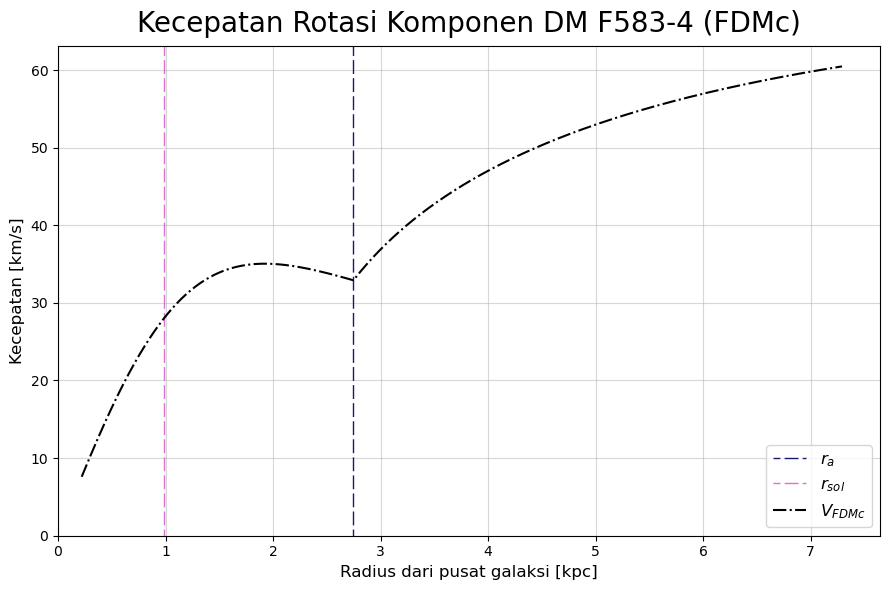

In [42]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
#plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
#plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
#plt.plot(rad, Vdisk_f, label = '$V_{disk}$', c = "blue", linewidth = 1.5, linestyle = 'dashed') # Komponen disk
#plt.plot(rad, Vgas, label = '$V_{gas}$', c = "green", linewidth = 1.5, linestyle = 'dotted') # Komponen gas
plt.axvline(x = ra, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_a$')
plt.axvline(x = rs, c = 'orchid', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_{sol}$')
plt.plot(rsmooth, vDM, label = '$V_{FDMc}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('Kecepatan Rotasi Komponen DM {} (FDMc)'.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.5)
plt.savefig('Kecepatan Rotasi Komponen DM MAP {} (FDMc).jpg'.format(df['ID'][0]), format = 'jpg', dpi = 150)
plt.show()

## Fraksi Dark Matter

In [43]:
# Interpolasi Kubik Profil Kecepatan
c1 = CubicSpline(rad, vtot)
c2= CubicSpline(rad, Vdisk_f)
c3 = CubicSpline(rad, Vgas)
c4 = CubicSpline(rsmooth, vDM)

# Memperoleh nilai kecepatan di radius efektif
total = c1(r_eff)
bintang = c2(r_eff)
gas = c3(r_eff)
dm = c4(r_eff)

# Print
print(f"At x = {r_eff}, total = {total}")
print(f"At x = {r_eff}, bintang = {bintang}")
print(f"At x = {r_eff}, gas = {gas}")
print(f"At x = {r_eff}, dm = {dm}")

At x = 3.31, total = 50.53560147672047
At x = 3.31, bintang = 27.06619644293662
At x = 3.31, gas = 7.537664949392293
At x = 3.31, dm = 40.76708836264389


In [44]:
#Massa Baryon
G = 4.3e-6
Mstar = ML_d*(M_star_a)*(1-(1+r_eff/r_star)*np.exp(-r_eff/r_star))
Mgas = (M_gas_a)*(1-(1+r_eff/r_gas)*np.exp(-r_eff/r_gas))
M_bar = Mstar + Mgas
M_bar

549387656.2526948

In [45]:
#Massa DM
M_dm = (dm**2 * r_eff)/G
M_dm

1279319228.7694895

In [46]:
#Fraksi DM
frac = M_dm/(M_bar+M_dm)
frac

0.6995758802285965

In [47]:
# Use the spline interpolator to get the interpolated y-value
r_opt = (3.2/1.69)*r_eff
total1 = c1(r_opt)
bintang1 = c2(r_opt)
gas1 = c3(r_opt)
dm1 = c4(r_opt)

# Print or use the result as needed
print(f"At x = {r_opt}, total = {total1}")
print(f"At x = {r_opt}, bintang = {bintang1}")
print(f"At x = {r_opt}, gas = {gas1}")
print(f"At x = {r_opt}, dm = {dm1}")

At x = 6.267455621301775, total = 65.3608929647324
At x = 6.267455621301775, bintang = 27.544617258386005
At x = 6.267455621301775, gas = 13.133629775559529
At x = 6.267455621301775, dm = 57.80180051823734


In [48]:
Mstar1 = ML_d*(M_star_a)*(1-(1+r_opt/r_star)*np.exp(-r_opt/r_star))
Mgas1 = (M_gas_a)*(1-(1+r_opt/r_gas)*np.exp(-r_opt/r_gas))
M_bar1 = Mstar1 + Mgas1
M_bar

549387656.2526948

In [49]:
M_dm1 = (dm1**2 * r_opt)/G
M_dm1

4869737433.913016

In [50]:
frac1 = M_dm1/(M_bar1+M_dm1)
frac1

0.8308819573816065

In [51]:
np.savetxt('Parameter {} (FDMc).txt'.format(df['ID'][0]), np.c_[C200, C200n, rs, ra, r200, m200, red_chisq, frac, frac1], fmt='% 1.3f', header='C200    C200n     rs     ra     r200    m200     rcs    frac   frac_o')